In [1]:
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

import torch
import torch.nn as nn

In [2]:
resource_path = os.path.join(".", 'data', 'ml-25m')
movies_csv = os.path.join(resource_path, 'movies.csv')
links_csv = os.path.join(resource_path, 'links.csv')

In [3]:
movies = pd.read_csv(movies_csv)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies['genres'] = movies.genres.apply(lambda genres: genres.split('|'))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [5]:
links = pd.read_csv(links_csv)
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [6]:
movies = movies.merge(links)
del links

movies

,movieId,title,genres,imdbId,tmdbId
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",114709,862.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",113497,8844.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",113228,15602.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",114885,31357.0
4,5,Father of the Bride Part II (1995),[Comedy],113041,11862.0
...,...,...,...,...,...
62418,209157,We (2018),[Drama],6671244,499546.0
62419,209159,Window of the Soul (2001),[Documentary],297986,63407.0
62420,209163,Bad Poems (2018),"[Comedy, Drama]",6755366,553036.0
62421,209169,A Girl Thing (2001),[(no genres listed)],249603,162892.0


In [7]:
model_path = os.path.join(".", 'models', 'binaries')
models = [model for model in os.listdir(model_path) if model.endswith(".pth")]
models.sort()
models

final_model = models[-1]
final_model_path = os.path.join(model_path, final_model)
final_model_path

'.\\models\\binaries\\Embedding_weights_Final.pth'

In [8]:
embedding_state = torch.load(final_model_path)

n_users = embedding_state['n_users']
n_movies = embedding_state['n_movies']
n_factors = embedding_state['n_factors']

movie_bias = embedding_state['state_dict']['movie_bias.weight']
movie_factors = embedding_state['state_dict']['movie_factors.weight']

userLabel_to_Id = embedding_state["userLabel_to_Id"]
movieLabel_to_Id = embedding_state["movieLabel_to_Id"]

del embedding_state

c:\ProgramData\anaconda3\envs\ncf\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.3.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
def get_movie_id(label):
    id = movieLabel_to_Id([label])
    return id.item(0)

movies_dict = {
    'label': [],
    'title': [],
    'genres':  [],
    'imdbId': []
}

for label in range(n_movies):
    movies_dict['label'].append(label)
    movies_dict['title'].append(movies[movies['movieId']==get_movie_id(label)]['title'].item())
    movies_dict['genres'].append(movies[movies['movieId']==get_movie_id(label)]['genres'].item())
    movies_dict['imdbId'].append(movies[movies['movieId']==get_movie_id(label)]['imdbId'].item())

movies = pd.DataFrame(movies_dict)
del movies_dict
movies

,label,title,genres,imdbId
0,0,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",114709
1,1,Jumanji (1995),"[Adventure, Children, Fantasy]",113497
2,2,Heat (1995),"[Action, Crime, Thriller]",113277
3,3,GoldenEye (1995),"[Action, Adventure, Thriller]",113189
4,4,Ace Ventura: When Nature Calls (1995),[Comedy],112281
...,...,...,...,...
195,195,Up (2009),"[Adventure, Animation, Children, Drama]",1049413
196,196,Avatar (2009),"[Action, Adventure, Sci-Fi, IMAX]",499549
197,197,Inception (2010),"[Action, Crime, Drama, Mystery, Sci-Fi, Thrill...",1375666
198,198,Django Unchained (2012),"[Action, Drama, Western]",1853728


In [10]:
def get_movie_name(label):
    return movies[movies['label']==label]['title'].item()

In [11]:
min_bias = movie_bias.min().item()
max_bias = movie_bias.max().item()

ranked_labels = movie_bias.argsort(0, descending=True).squeeze().tolist()
for i, label in enumerate(ranked_labels):
    print(f"{i+1}. {get_movie_name(label)}")

1. Shawshank Redemption, The (1994)
2. Godfather, The (1972)
3. Usual Suspects, The (1995)
4. Godfather: Part II, The (1974)
5. Schindler's List (1993)
6. Fight Club (1999)
7. One Flew Over the Cuckoo's Nest (1975)
8. Pulp Fiction (1994)
9. Dark Knight, The (2008)
10. Matrix, The (1999)
11. Silence of the Lambs, The (1991)
12. American Beauty (1999)
13. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
14. Goodfellas (1990)
15. American History X (1998)
16. Inception (2010)
17. Rear Window (1954)
18. Monty Python and the Holy Grail (1975)
19. Casablanca (1942)
20. Spirited Away (Sen to Chihiro no kamikakushi) (2001)
21. Memento (2000)
22. Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
23. Star Wars: Episode V - The Empire Strikes Back (1980)
24. Princess Bride, The (1987)
25. Blade Runner (1982)
26. Life Is Beautiful (La Vita è bella) (1997)
27. Star Wars: Episode IV - A New Hope (1977)
28. Lord of the Rings: The Return of the K

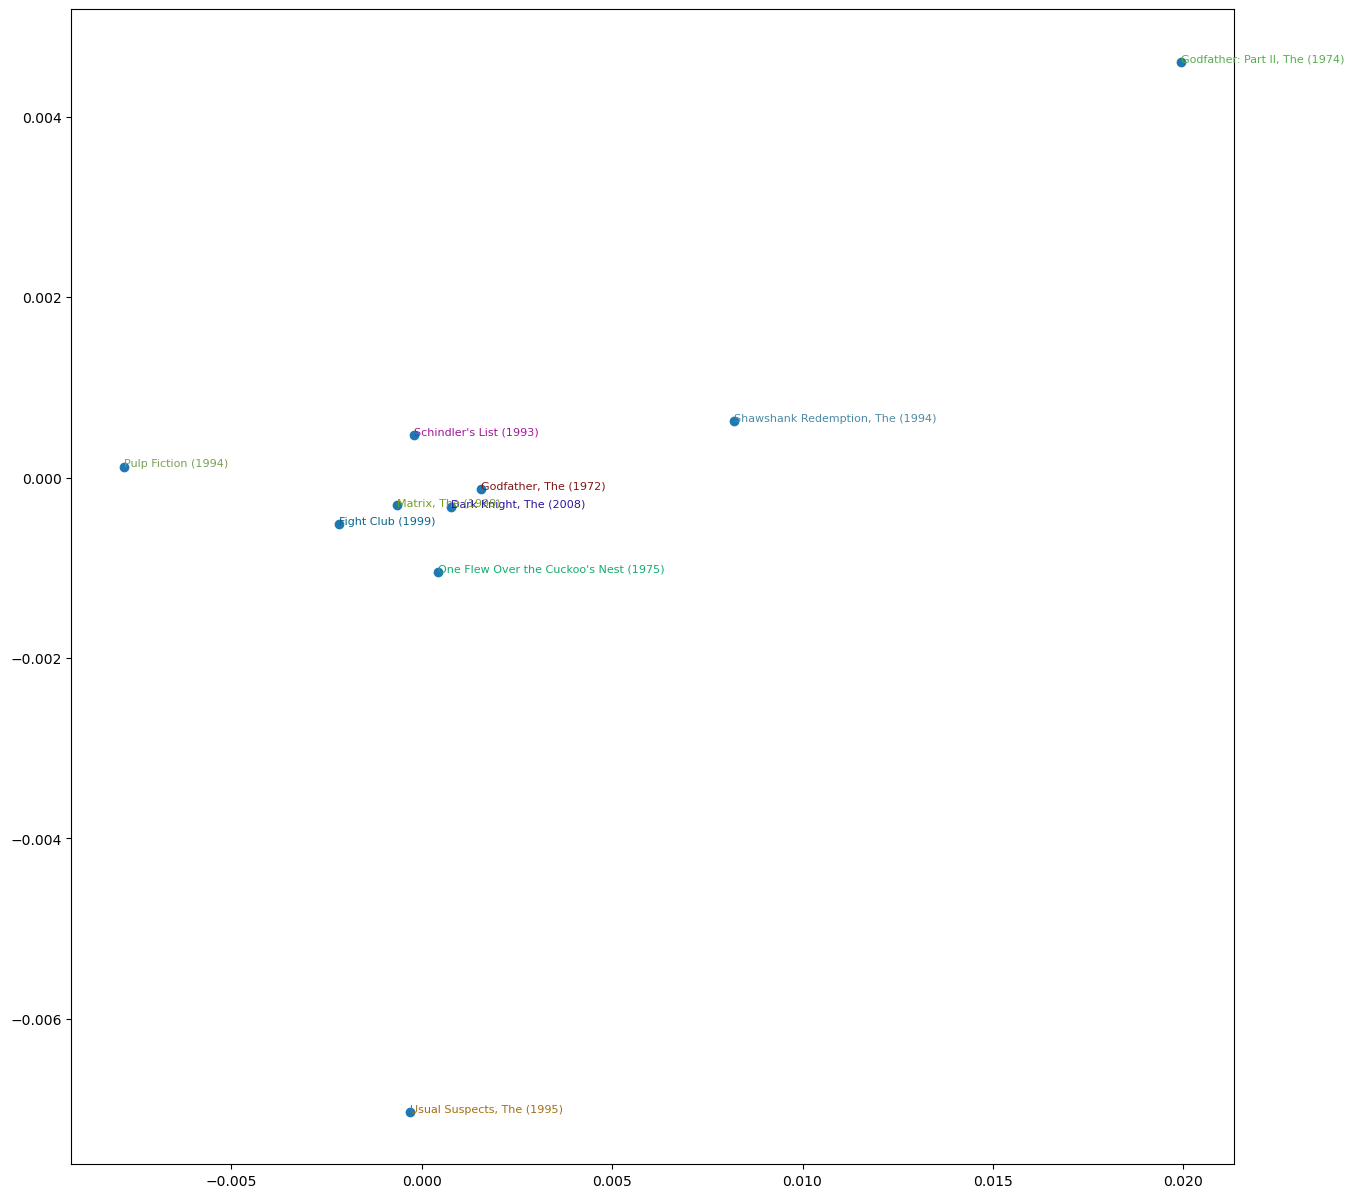

In [12]:
top_n = 10
top_n_labels = ranked_labels[:top_n]

pca = PCA(n_components=2)
reduced_embed = pca.fit_transform(movie_factors)
X = reduced_embed[top_n_labels][:,0]
Y = reduced_embed[top_n_labels][:,1]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for label, x, y in zip(top_n_labels,X, Y):
    plt.text(x,y, get_movie_name(label), color=np.random.rand(3)*0.7, fontsize=8)

In [13]:
def get_closest_labels(label):
    distances = nn.CosineSimilarity(dim=1)(movie_factors, torch.unsqueeze(movie_factors[label], dim=0))

    closest_labels = distances.argsort(0).squeeze().tolist()
    closest_labels.remove(label)
    return closest_labels

label = 30
closest_labels = get_closest_labels(label)

top_n = 20
print(f"Top {top_n} Closest Movies to {get_movie_name(label)} :")
for i, label in enumerate(closest_labels[:top_n]):
    print(f"{i+1}. {get_movie_name(label)}")

Top 20 Closest Movies to Shawshank Redemption, The (1994) :
1. Pulp Fiction (1994)
2. Sleepless in Seattle (1993)
3. American Pie (1999)
4. Lord of the Rings: The Return of the King, The (2003)
5. Princess Bride, The (1987)
6. Harry Potter and the Chamber of Secrets (2002)
7. Jurassic Park (1993)
8. Incredibles, The (2004)
9. Contact (1997)
10. Bug's Life, A (1998)
11. Monty Python and the Holy Grail (1975)
12. Good Will Hunting (1997)
13. Mission: Impossible (1996)
14. Big Lebowski, The (1998)
15. Willy Wonka & the Chocolate Factory (1971)
16. Austin Powers: International Man of Mystery (1997)
17. Up (2009)
18. Star Wars: Episode I - The Phantom Menace (1999)
19. Minority Report (2002)
20. True Lies (1994)


In [14]:
def get_recommendations(label, weight=1, bias_weight=1, recommendations=dict()):
    if bias_weight>1: bias_weight=1

    closest_labels = get_closest_labels(label)
    n = len(closest_labels)

    for i, label in enumerate(closest_labels):
        new_rating = recommendations.get(label, 0) + weight * ( (n-i) * ((bias_weight * movie_bias[label].item()) + 1) )
        recommendations[label] = new_rating

    return recommendations

label = 196
weight = 1
bias_weight = 0.3

recommendations = get_recommendations(label, weight, bias_weight)
recommendations = sorted(recommendations.items(), key=lambda x:x[1], reverse=True)
recommendations = [label for label, _ in recommendations]


top_n = 20
print(f"Top {top_n} Recommended Movies for people who like {get_movie_name(label)} :")
for i, label in enumerate(recommendations[:top_n]):
    print(f"{i+1}. {get_movie_name(label)}")

Top 20 Recommended Movies for people who like Avatar (2009) :
1. Fargo (1996)
2. Office Space (1999)
3. American Beauty (1999)
4. Batman Begins (2005)
5. Ghostbusters (a.k.a. Ghost Busters) (1984)
6. Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)
7. Forrest Gump (1994)
8. Bourne Identity, The (2002)
9. Get Shorty (1995)
10. Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)
11. Rear Window (1954)
12. Sixth Sense, The (1999)
13. Blues Brothers, The (1980)
14. Airplane! (1980)
15. Gladiator (2000)
16. Groundhog Day (1993)
17. Silence of the Lambs, The (1991)
18. Die Hard (1988)
19. Inglourious Basterds (2009)
20. Matrix Reloaded, The (2003)


In [15]:
user_ratings = [(30, 4.8), (0, 3.5), (196, 3.0), (2, 2.3)]

recommendations = dict()
bias_weight = 0.3

for label, rating in user_ratings:
    recommendations = get_recommendations(label, rating, bias_weight, recommendations)

recommendations = sorted(recommendations.items(), key=lambda x:x[1], reverse=True)
recommendations = [label for label, _ in recommendations]

top_n = 20
print(f"Top {top_n} Recommended Movies :")
for i, label in enumerate(recommendations[:top_n]):
    print(f"{i+1}. {get_movie_name(label)}")

Top 20 Recommended Movies :
1. Matrix, The (1999)
2. Big Lebowski, The (1998)
3. Pulp Fiction (1994)
4. Princess Bride, The (1987)
5. Eternal Sunshine of the Spotless Mind (2004)
6. Good Will Hunting (1997)
7. Harry Potter and the Chamber of Secrets (2002)
8. Silence of the Lambs, The (1991)
9. Beautiful Mind, A (2001)
10. Monty Python and the Holy Grail (1975)
11. Blues Brothers, The (1980)
12. Inglourious Basterds (2009)
13. Green Mile, The (1999)
14. Die Hard (1988)
15. Goodfellas (1990)
16. American Beauty (1999)
17. Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)
18. Spirited Away (Sen to Chihiro no kamikakushi) (2001)
19. Incredibles, The (2004)
20. Willy Wonka & the Chocolate Factory (1971)
